In [1]:
#Principle Component Analysis and XGBoost
import numpy as np
import pandas as pd 
df1 = pd.read_csv('data/cleaned_data.csv')
df1.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,...,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,0.0,No
1,1,2008-12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,...,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,0.0,No
2,2,2008-12-03,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,...,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,0.0,No
3,3,2008-12-04,Albury,9.2,28.0,0.0,NE,24.0,SE,E,...,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,1.0,No
4,4,2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,...,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,0.2,No


In [3]:
df1['RainToday'].replace({'No':0,'Yes':1},inplace = True)    
df1['RainTomorrow'].replace({'No':0,'Yes':1},inplace = True)   # replacing label's values
df = df1.drop(['Date'],axis=1)  # Insignificant feature
df.shape

(142193, 20)

In [4]:
categorical_features = df.select_dtypes(include = ["object"]).columns
categorical_features

Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [5]:
#Creating Dummy variables in every categorical column
df = pd.get_dummies(df,columns=categorical_features,drop_first=True)

In [6]:
df.isnull().sum(axis=0)

Unnamed: 0        0
MinTemp           0
MaxTemp           0
Rainfall          0
WindGustSpeed     0
                 ..
WindDir3pm_SSW    0
WindDir3pm_SW     0
WindDir3pm_W      0
WindDir3pm_WNW    0
WindDir3pm_WSW    0
Length: 109, dtype: int64

In [7]:
df = df.fillna(df.mean())

In [9]:
#Scaling all values from dataset
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() 

scaled = scaler.fit_transform(df) 

In [10]:
scaled

array([[-1.73203863,  0.1899065 , -0.05055537, ..., -0.27679621,
         3.86627351, -0.26835412],
       [-1.73201426, -0.74980987,  0.26251425, ..., -0.27679621,
        -0.25864699,  3.72641944],
       [-1.7319899 ,  0.11159681,  0.34789688, ..., -0.27679621,
        -0.25864699,  3.72641944],
       ...,
       [ 1.7319899 , -1.34496357,  0.29097513, ..., -0.27679621,
        -0.25864699, -0.26835412],
       [ 1.73201426, -1.06304866,  0.51866212, ..., -0.27679621,
         3.86627351, -0.26835412],
       [ 1.73203863, -0.68716211,  0.53289256, ..., -0.27679621,
        -0.25864699, -0.26835412]])

In [15]:
from sklearn.decomposition import PCA 
  
pca_model = PCA(n_components = 2) 
pca = pca_model.fit_transform(scaled)  
#But we dont know if the component value is suitable with 2 or any other number.
#Let's check for n_components=2 (reference)

In [19]:
variance=np.var(pca,axis=0)
variance_ratio = variance/np.sum(variance)
print(variance_ratio)

[0.61369451 0.38630549]


Text(0, 0.5, 'Second Principal Component')

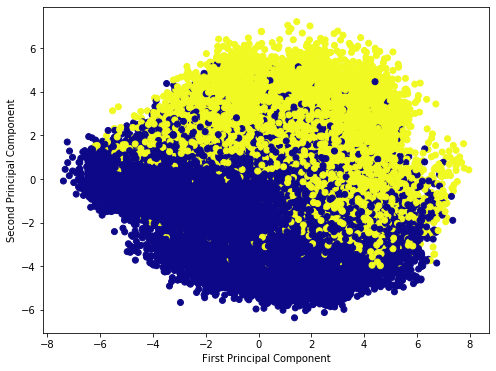

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize =(8, 6)) 
  
plt.scatter(pca[:, 0], pca[:, 1], c = df1['RainTomorrow'], cmap ='plasma') 
  
plt.xlabel('First Principal Component') 
plt.ylabel('Second Principal Component') 

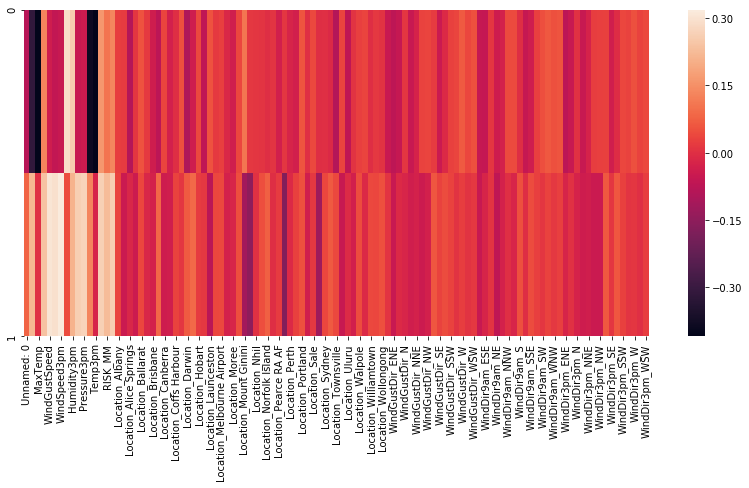

In [21]:
#Find correlation between both components as how close their covariance are.
import seaborn as sns
df_comp = pd.DataFrame(pca_model.components_, columns = df.columns)
  
plt.figure(figsize =(14, 6)) 
  
sns.heatmap(df_comp) 

In [22]:
#Trying to train new dataset to algorithm
test = df.copy()
test = test["RainTomorrow"].values

In [23]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(pca, test, test_size = 0.25) 

In [28]:
#Import xgboost
#XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.
import xgboost as xgb
xgb = xgb.XGBClassifier() 
xgb.fit(X_train, y_train) 
y_pred = xgb.predict(X_test) 

In [30]:
#Predictions 
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.397395


In [31]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f" % (accuracy * 100.0))

Accuracy: 84.21


In [ ]:
#Root Mean Square Error (RMSE) & Accuracy Score is pretty good. It means PCA can be used whenever we have a number of dimensions/features